**Animal Faces Classifer using Transfer Learning**

The dataset has 3 classes namely Cat, Dog and Wild. We are building a classification algorithm using Transfer Learning from MobileNet V2

Author: Venkatesan Krishnamurthy

**Loading the essential libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
import os
import pickle

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip '/content/drive/MyDrive/Transfer_Learning/archive.zip' -d '/content/drive/MyDrive/Transfer_Learning'

**Loading and Preprocessing the Data**

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Transfer_Learning/afhq/train",
                                                                  labels='inferred', label_mode='int', color_mode='rgb',
                                                                  batch_size=128, image_size=(224, 224), shuffle=True,
                                                                  seed=123, subset="training", validation_split=0.2, interpolation='bilinear')

Found 13791 files belonging to 3 classes.
Using 11033 files for training.


In [5]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Transfer_Learning/afhq/train",
                                                                  labels='inferred', label_mode='int', color_mode='rgb',
                                                                  batch_size=128, image_size=(224, 224), shuffle=True,
                                                                  seed=123, subset="validation", validation_split=0.2, interpolation='bilinear')

Found 13791 files belonging to 3 classes.
Using 2758 files for validation.


In [6]:
def normalize_images(image, label):
  """
  normalize images to 0-1 range.
  This function uses two inputs because the tf dataset has images and labels together and both are required if we were to use the map function
  """
  image = image / 255.0
  return image, label

In [7]:
train_dataset = train_dataset.map(normalize_images)
val_dataset = val_dataset.map(normalize_images)

**Visualising the Dataset**

In [8]:
class_dict = {0: "Cat", 1: "Dog", 2: "Wild"}

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    """
    Function to convert tensorflow datasets to numpy arrays

    Inputs:
    1. dataset: The tensorflow dataset generated from functions such as tf.keras.preprocessing.image_dataset_from_directory()
    2. batch_size (int): The size of a batch. Example: if a dataset has 100 images and batch size is given as 20, then 5 batches are created each having 20 samples.
    3. N (int): The number of samples you want to see from the dataset. Useful when you want to see only how certain samples look like.
                If your dataset has images in batches, then this will choose number of batches instead of samples 

    Output:
    Gives a tuple of input samples and labels in numpy form.
    """

    #take_dataset = dataset.shuffle(1024)  # not shuffling for viewing because we already shuffled our data while loading
    take_dataset = dataset

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_labels = [], []
        for image, label in take_dataset:
            ds_images.append(image.numpy())
            ds_labels.append(label.numpy())
        
    return (np.array(ds_images), np.array(ds_labels))

In [10]:
# Removing Validation split here and reducing the batch size since we use this to only visualize few images. Inserting validation split results in huge computational time
visualize_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Transfer_Learning/afhq/train",
                                                                  labels='inferred', label_mode='int', color_mode='rgb',
                                                                  batch_size=10, image_size=(224, 224), shuffle=True,
                                                                  seed=1, interpolation='bilinear')

visualize_dataset = visualize_dataset.map(normalize_images)

(vis_images, vis_labels) = dataset_to_numpy_util(visualize_dataset, N=1) # choosing only one batch of 10 samples

Found 13791 files belonging to 3 classes.


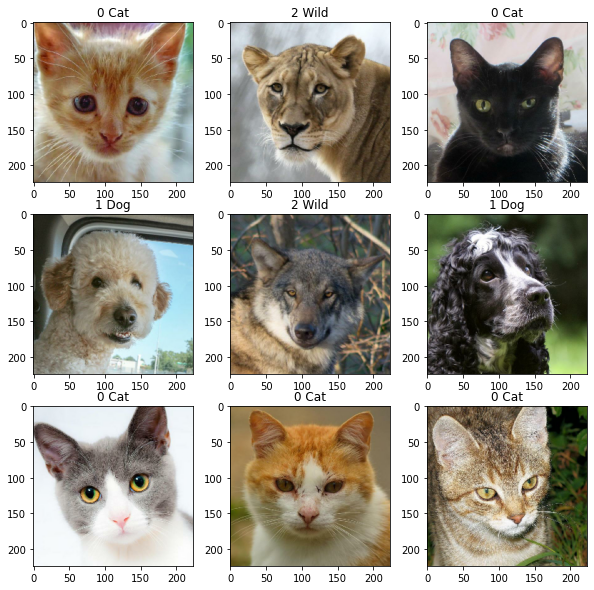

In [11]:
fig, ax = plt.subplots(3, 3, figsize = (10,10))
ax = ax.ravel()
for i in range(0,9):
    ax[i].imshow(vis_images[0,i]) 
    title = str(vis_labels[0,i]) + " " + class_dict[vis_labels[0,i]]
    ax[i].title.set_text(title)

**Model Building and Compiling**

In [12]:
def cnn_model(inputs):    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet") 

    # Setting the weights of mobilenet to be non-trainable
    for layer in mobilenet_model.layers:
      layer.trainable = False

    # pass the inputs into this modle object to get a feature extractor for these inputs
    cnn_output = mobilenet_model(inputs)

    return cnn_output

In [13]:
def dense_layers(trained_cnn_model_output):
    # Dense layers whose weights will train on every iteration
    
    x = GlobalAveragePooling2D(name="Global_Average_Pooling")(trained_cnn_model_output)  
    x = Flatten(name = "Flatten")(x)
    x = Dense(512, "relu", name="Dense_1")(x)
    x = Dense(64, "relu", name="Dense_2")(x)
    x = Dense(3, "softmax", name= "Output")(x)
    return x

In [14]:
def create_and_compile_model():
  # Putting all together 

  inp = Input(shape=(224,224,3), name = "Input")
  cnn_output = cnn_model(inp)
  out = dense_layers(cnn_output)

  model = Model(inputs=inp, outputs=out, name="fixed_cnn_weights_model")

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

In [15]:
# Creating, Compiling and Summary of the Model
model = create_and_compile_model()
model.summary()

Model: "fixed_cnn_weights_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
Global_Average_Pooling (Glob (None, 1280)              0         
_________________________________________________________________
Flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
Output (Dense)               (None, 3)     

**Model Training**

In [16]:
file_path = "/content/drive/MyDrive/Transfer_Learning/afhq/model_checkpoints/saved-model-{epoch:02d}.h5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_freq="epoch", save_weights_only=False)
history = model.fit(x=train_dataset, epochs=5, callbacks=[callback], verbose=2)

Epoch 1/5
87/87 - 2678s - loss: 0.0376 - accuracy: 0.9859
Epoch 2/5
87/87 - 456s - loss: 0.0087 - accuracy: 0.9971
Epoch 3/5
87/87 - 456s - loss: 0.0045 - accuracy: 0.9985
Epoch 4/5
87/87 - 461s - loss: 0.0026 - accuracy: 0.9992
Epoch 5/5
87/87 - 451s - loss: 0.0020 - accuracy: 0.9992


**Model Evaluation**

In [17]:
model.evaluate(val_dataset)

22/22 [==============================] - 693s 21s/step - loss: 0.0082 - accuracy: 0.9989


[0.008188693784177303, 0.9989122748374939]

The model gives 99.89% accuracy on the validation data


---



**References**


1.   Dataset: https://www.kaggle.com/andrewmvd/animal-faces
2.   Found this course to be helpful in gaining knowledge about Transfer Learning: https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow

